# Examples of plotting TrackRun subsets

Import the necessary modules

**NB** examples below require `cartopy` package to be installed

In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr

from octant.core import TrackRun, OctantTrack, HOUR

To save time, in this example `lcc_map` function from `arke` package is used to create a map in Lambert Conformal Conic projection.

`arke` can be installed by running
```bash
pip install git+https://github.com/dennissergeev/arke.git
```
Note: it requires [iris](http://scitools.org.uk/iris/) package to be installed too.

Alternatively, there are plenty of examples in `cartopy` docs on how to create geoaxes.

In [2]:
try:
    from arke.cart import lcc_map
except ImportError:
    # arke package is not installed or fails to import
    # so let's define lcc_map() instead
    
    def lcc_map(fig, subplot_grd=111, clon=None, clat=None, coast=None, extent=None):
        """ Create cartopy axes in Lambert Conformal projection """
        proj = ccrs.LambertConformal(central_longitude=clon,
                                     central_latitude=clat)

        # Draw a set of axes with coastlines:
        ax = fig.add_subplot(subplot_grd, projection=proj)
        if isinstance(extent, list):
            ax.set_extent(extent, crs=ccrs.PlateCarree())
        if isinstance(coast, dict):
            feature = cartopy.feature.NaturalEarthFeature(name='coastline',
                                                          category='physical',
                                                          **coast)
            ax.add_feature(feature)
        return ax

Some useful declarations for plotting...

In [3]:
plt.rcParams['figure.figsize'] = (15, 10)  # change the default figure size
COAST = dict(scale='50m', alpha=0.5,
             edgecolor='#333333', facecolor='#AAAAAA')
clon = 10
clat = 75
extent = [-20, 50, 65, 85]
LCC_KW = dict(clon=clon, clat=clat, coast=COAST, extent=extent)

mapkw = dict(transform=ccrs.PlateCarree())

Define the common data directory

In [4]:
sample_dir = Path('.') / 'sample_data'

Data are usually organised in hierarchical directory structure. Here, the relevant parameters are defined.

In [5]:
dataset = 'era5'
period = 'test'
run_id = 0

Construct the full path

In [6]:
track_res_dir = sample_dir / dataset / f'run{run_id:03d}' / period

## Load the data

Load land-sea mask array from ERA5 dataset:

In [7]:
lsm = xr.open_dataarray(sample_dir / dataset / 'lsm.nc')
lsm = lsm.squeeze()  # remove singular time dimension

Now load the cyclone tracks themselves

In [8]:
TR = TrackRun(track_res_dir)

... and classify them

In [9]:
TR.categorise(lsm=lsm, filt_by_dist=False, filt_by_land=True, filt_by_domain_bounds=True, coast_rad=50)

Here's what 'moderate' subset looks like after classification. Level-0 Multi-Index (`track_idx`) is preserved, i.e. indices are not reset to 0 for each subset.

In [10]:
TR['moderate']

lon   lat        vo                time         area  \
track_idx row_idx                                                          
4         0        30.3  71.1  0.000242 2011-01-01 00:00:00   4357.06738   
          1        30.3  71.1  0.000231 2011-01-01 01:00:00   3634.56909   
          2        30.3  71.1  0.000228 2011-01-01 02:00:00   4001.33765   
          3        30.3  71.1  0.000227 2011-01-01 03:00:00   4001.33765   
          4        30.0  71.1  0.000220 2011-01-01 04:00:00   4362.58691   
          5        30.6  70.8  0.000213 2011-01-01 05:00:00   4001.33765   
          6        30.6  70.8  0.000213 2011-01-01 06:00:00   3273.32007   
          7        30.6  70.8  0.000217 2011-01-01 07:00:00   4723.83594   
          8        30.6  70.8  0.000217 2011-01-01 08:00:00   5085.08496   
          9        30.6  70.8  0.000201 2011-01-01 09:00:00   5085.08496   
41        0       -12.6  78.0  0.000210 2011-01-01 21:00:00  20232.74414   
          1       -12.0  78.0  0.000227 2011-01-01 22:00:00  16825.84180   
          2       -11.7  78.0  0.000218 2011-01-01 23:00:00  17266.85547   
          3       -10.8  78.0  0.000209 2011-01-02 00:00:00  15561.05469   
          4        -9.3  78.3  0.000219 2011-01-02 01:00:00  16494.07031   
          5        -8.7  78.3  0.000226 2011-01-02 02:00:00  16279.27539   
          6        -8.1  78.3  0.000223 2011-01-02 03:00:00  15351.86328   
          7        -7.5  78.3  0.000219 2011-01-02 04:00:00  15051.43359   
          8        -7.5  77.7  0.000222 2011-01-02 05:00:00  15286.41406   
          9        -7.2  77.7  0.000213 2011-01-02 06:00:00  15692.66797   
          10       -6.9  77.7  0.000201 2011-01-02 07:00:00  14934.23242   
          11       -6.3  78.9  0.000209 2011-01-02 08:00:00  15017.20410   
          12       -6.0  78.9  0.000216 2011-01-02 09:00:00  12890.33105   
          13       -5.4  78.9  0.000213 2011-01-02 10:00:00  11934.25684   
          14       -5.4  78.9  0.000216 2011-01-02 11:00:00  11401.68164   
          15       -5.1  78.9  0.000204 2011-01-02 12:00:00  10780.51172   
55        0       -19.5  78.3  0.000209 2011-01-02 15:00:00   1130.79248   
          1       -19.5  78.3  0.000215 2011-01-02 16:00:00   1356.95093   
          2       -19.5  78.3  0.000220 2011-01-02 17:00:00   2232.97314   
          3       -19.5  78.3  0.000252 2011-01-02 18:00:00   3131.86816   
...                 ...   ...       ...                 ...          ...   
641       11       41.1  75.3  0.000278 2011-01-31 06:00:00   5060.13770   
          12       40.5  75.3  0.000302 2011-01-31 07:00:00   5399.62354   
          13       39.9  75.0  0.000293 2011-01-31 08:00:00   5750.35010   
          14       39.3  75.0  0.000307 2011-01-31 09:00:00   6078.48486   
          15       38.7  74.7  0.000295 2011-01-31 10:00:00   6474.21143   
          16       38.4  74.4  0.000256 2011-01-31 11:00:00   5353.40576   
          17       37.5  74.4  0.000244 2011-01-31 12:00:00   5132.24072   
          18       37.2  74.1  0.000220 2011-01-31 13:00:00   5771.40918   
          19       36.6  74.1  0.000243 2011-01-31 14:00:00   3971.93091   
644       0        12.3  66.9  0.000204 2011-01-30 20:00:00   2630.65356   
          1        12.6  67.2  0.000255 2011-01-30 21:00:00   3468.13379   
          2        12.3  66.9  0.000395 2011-01-30 22:00:00  21973.78516   
          3        12.6  67.2  0.000529 2011-01-30 23:00:00  19843.12109   
          4        13.2  67.5  0.000418 2011-01-31 00:00:00  17274.18945   
          5        13.8  67.8  0.000325 2011-01-31 01:00:00  10344.45020   
          6        14.4  68.4  0.000205 2011-01-31 02:00:00   2085.27441   
654       0        17.1  70.8  0.000552 2011-01-31 04:00:00  35305.15625   
          1        17.7  70.8  0.000588 2011-01-31 05:00:00  35867.32812   
          2        18.0  70.8  0.000593 2011-01-31 06:00:00  37030.48828   
          3        18.3  70.8  0.000536 2011-01-31 07:00:00  38058.8

1942 rows in total, but that's all timesteps of all PMCs. The actual number of PMCs is

In [11]:
TR.size('moderate')

90

What are their indices?

In [12]:
TR['moderate'].index.get_level_values('track_idx').unique()

Int64Index([  4,  41,  55,  70,  84,  86,  88, 102, 114, 117, 122, 131, 135,
            139, 140, 160, 163, 165, 176, 182, 185, 186, 200, 216, 218, 234,
            250, 251, 252, 257, 258, 260, 267, 268, 278, 280, 292, 296, 297,
            302, 306, 311, 313, 319, 327, 331, 338, 339, 346, 347, 360, 361,
            366, 367, 373, 377, 385, 425, 445, 446, 461, 513, 527, 540, 543,
            546, 553, 561, 565, 569, 570, 575, 576, 579, 588, 589, 590, 592,
            594, 601, 602, 607, 621, 623, 629, 639, 641, 644, 654, 663],
           dtype='int64', name='track_idx')

## Simple track plot

Select an `OctantTrack` by its absolute index

In [13]:
import pandas as pd

In [14]:
random_track = TR['moderate'].loc[331]

`random_track` is a subclass of `pandas.DataFrame`, and it has the following additional attributes and methods:

In [15]:
set(random_track.__dir__()).difference(set(pd.DataFrame().__dir__()))

{'area',
 'average_speed',
 'cat',
 'coord_view',
 'from_df',
 'from_mux_df',
 'gen_lys_dist_km',
 'lat',
 'lifetime_h',
 'lon',
 'lonlat',
 'lonlat_c',
 'max_vort',
 'mean_vort',
 'plot_track',
 'time',
 'total_dist_km',
 'tridlonlat',
 'tridlonlat_c',
 'vo',
 'vortex_type'}

One of them is `plot_track()` method, which is a small wrapper around `matplotlib.pyplot.plot()` function.

The important (optional) parameter is `ax=`, via which a track can be plotted in the given axes. For example, below a figure `fig` is created along with `ax`, geo-referenced axes, and then the chosen track is added to the plot. The remaining parameters that can be passed to `plot_track` are keyword arguments of `matplotlib.pyplot.plot(*args, **kwargs)` function.

#### Plot a single track on a map

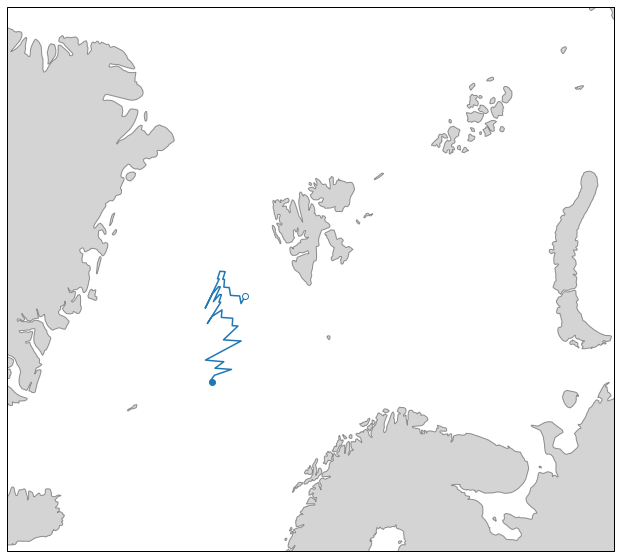

In [16]:
fig = plt.figure()
ax = lcc_map(fig, **LCC_KW)
random_track.plot_track(ax=ax, color=None);

#### Plot a single track without a map

##### a) In the given Axes

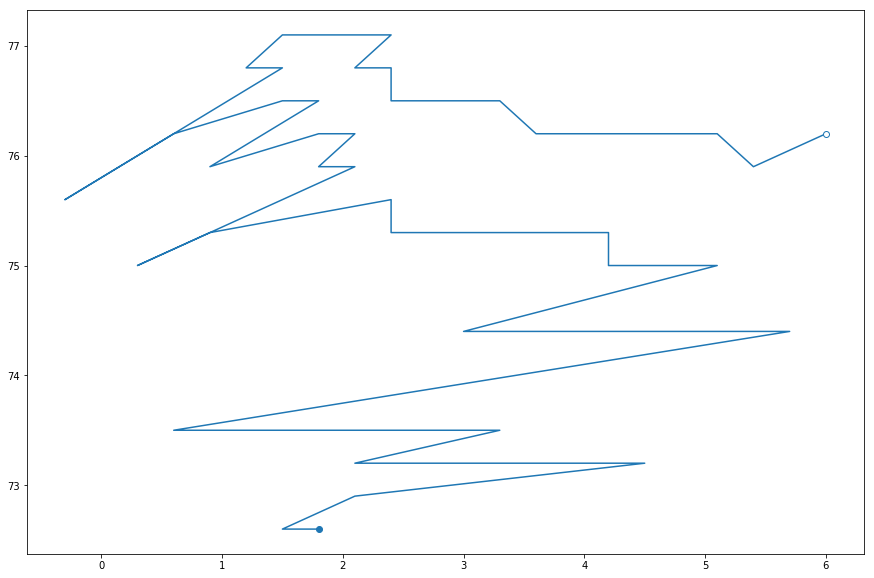

In [17]:
fig, ax = plt.subplots()
random_track.plot_track(ax=ax);

##### b) Or automatically create figure and axes in the `PlateCarree` projection

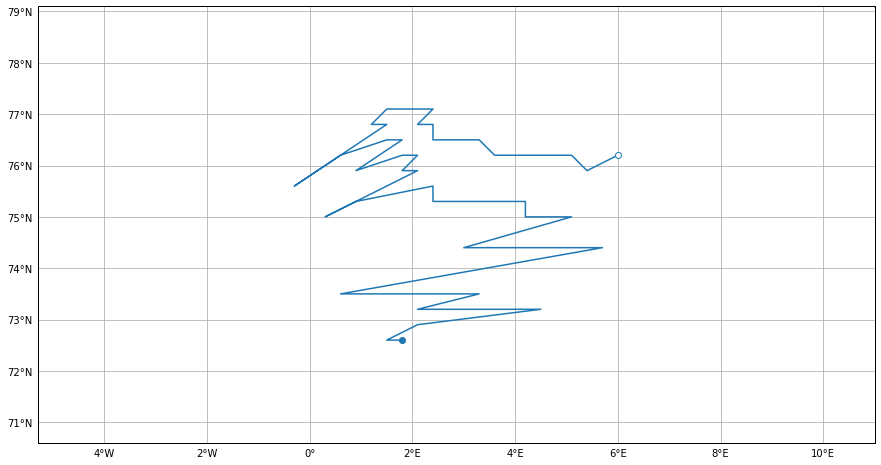

In [18]:
random_track.plot_track();

The function returns matplotlib axes object, so it can be used for further plotting.

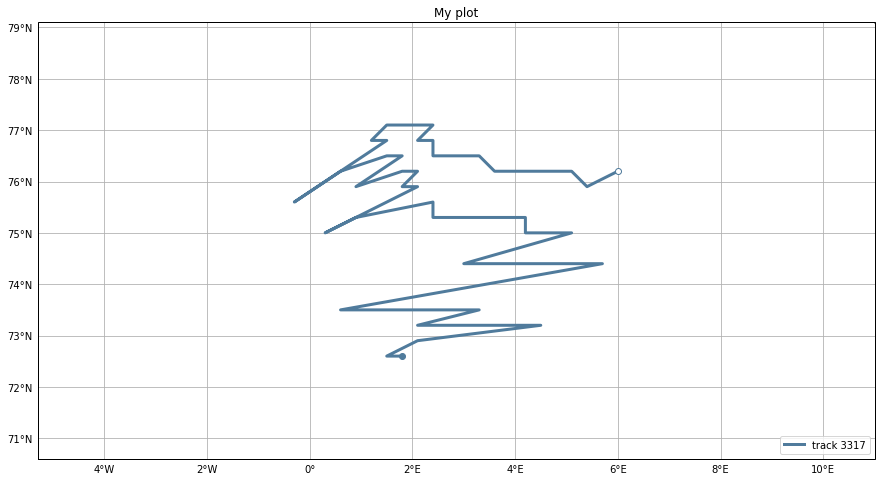

In [19]:
ax1 = random_track.plot_track(color='xkcd:stormy blue',
                              linewidth=3,
                              label=f'track 3317')
ax1.legend(loc=4)
ax1.set_title('My plot');

## Plot all tracks from TrackRun

In [20]:
subsets_and_colors = [
    ('basic', '#424242'),
    ('moderate', 'C0'),
    ('strong', 'C1')
]

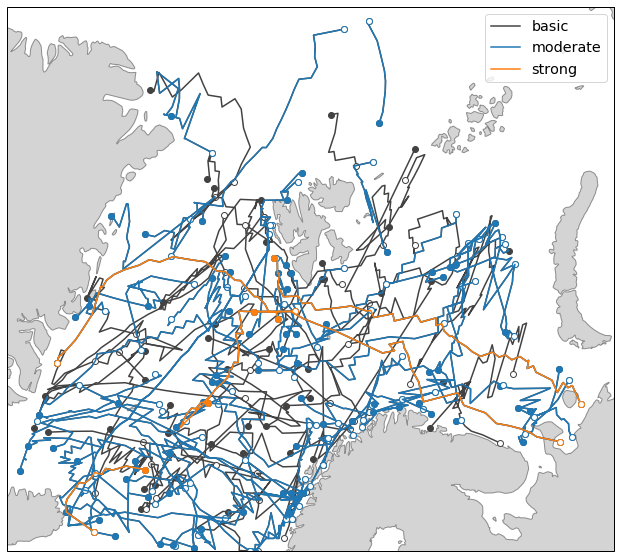

In [21]:
fig = plt.figure()
ax = lcc_map(fig, **LCC_KW)

handles, labels = [], []
for subset_label, color in subsets_and_colors:
    sub = TR[subset_label]
    for (_, track) in sub.groupby('track_idx'):
        track.plot_track(ax=ax, color=color, label=subset_label)
        
labels, handles = [list(getattr({j: i
                                for i, j in zip(*ax.get_legend_handles_labels())},
                                m)())
                   for m in ['keys', 'values']]
ax.legend(handles, labels, fontsize='x-large', loc=1);